In [6]:
import numpy as np
import os
from scipy import sparse as sp
import matplotlib.pyplot as plt
# Sorry for this code : (
import sys
sys.path.append('../')

from loader import get_newest_name

name = get_newest_name("tuning", "../doctors")
print(f"[{name}]")

p = os.path.abspath(f"../doctors/{name}/")

core = 0
w_in = sp.load_npz(os.path.join(p, f"w_in_{core}.npz")).toarray()
w = sp.load_npz(os.path.join(p, f"w_{core}.npz")).toarray()
w_out = np.load(os.path.join(p, f"w_out_{core}.npy"))
neurons = np.load(os.path.join(p, f"neurons_{core}.npy")).T

print("W_in", "max", "mean", "sd")
print(np.max(np.abs(w_in)), np.mean(w_in), np.std(w_in))

print("W", "max", "mean", "sd")
print(np.max(np.abs(w)), np.mean(w), np.std(w))

print("W_out", "max", "mean", "sd")
print(np.max(np.abs(w_out)), np.mean(w_out), np.std(w_out))

print("W spectral radius")
print(np.max(np.abs(np.linalg.eigvals(w))))
# 8.71841127316108

[tuning-34]
W_in max mean sd
0.9959937871458087 0.0019210093486486993 0.10761444629785992
W max mean sd
0.2477165563351428 0.0014676598246478301 0.045309365011937566
W_out max mean sd
58.88994031774325 -0.060852483394567565 6.772682762679039
W spectral radius
0.9800000000000044


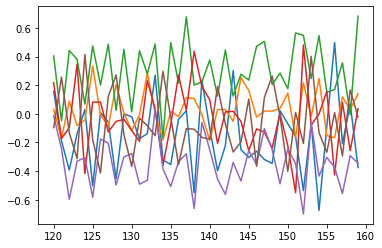

In [73]:
n = np.arange(neurons.shape[1])

window = 40
begin = 120
indicies = (n >= begin) & (n < (begin + window))

plt.plot(n[indicies], neurons[0][indicies])
plt.plot(n[indicies], neurons[1][indicies])
plt.plot(n[indicies], neurons[2][indicies])
plt.plot(n[indicies], neurons[3][indicies])
plt.plot(n[indicies], neurons[4][indicies])
plt.plot(n[indicies], neurons[5][indicies])


NRMSE: 0.8582104111067432


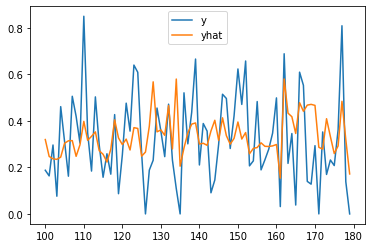

In [26]:
ys = np.load("../trash/ys.npy")
yhats = np.load("../trash/yhats.npy")

delta = np.mean((yhats - ys) * (yhats - ys), axis=0)
variances = np.var(ys, axis=0)
NMSE = delta / variances
NRMSE = np.sqrt(NMSE)
NRMSE = np.mean(NRMSE)

print(f"NRMSE: {NRMSE}")

y = ys.T
yhat = yhats.T
n = np.arange(ys.shape[0])

window = 80
begin = 100
indicies = (n >= begin) & (n < (begin + window))

plt.plot(n[indicies], y[0][indicies], label="y")
plt.plot(n[indicies], yhat[0][indicies], label="yhat")
plt.legend()